In [1]:
import numpy as np
from skimage import data, io, util
import matplotlib.pyplot as plt
import imageio
from PIL import Image
import numpy as np
import os
import cv2  
%matplotlib inline

In [2]:
nums = 17
height = 537
width = 720

In [3]:
# this function is for read image,the input is directory name
def read_directory(directory_name):
    imagelist = os.listdir(directory_name) 
    img_array = np.empty((nums,height,width,3))
    i = 0
    # this loop is for read each image in this foder,directory_name is the foder name with images.
    for filename in imagelist:
        #print(filename) #just for test
        #img is used to store the image data 
        img = cv2.imread(directory_name + filename)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_array[i] = img
        i = i + 1
        #print(img)
    
    return img_array


In [4]:
directory_name = './Test1_2/'
imagelist = os.listdir(directory_name) 
img_array = np.empty((nums,height,width,3))
i = 0
# this loop is for read each image in this foder,directory_name is the foder name with images.
for filename in imagelist:
    #print(filename) #just for test
    #img is used to store the image data 
    img = cv2.imread(directory_name + filename)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_array[i] = img
    i = i + 1
    #print(img)

In [5]:
img_array = read_directory('./Test1_2/')

In [6]:
EPI_img = np.empty((nums*height,width,3))
for rows in range(0,height):
    for s in range(0,17):
        EPI_img[rows*17+s,:,:]= img_array[s,rows,:,:] # img_array stores all the images in a 4-D matrix


In [9]:
EPI_img=EPI_img.astype(np.uint8)
EPI_img = Image.fromarray(EPI_img,'RGB')
EPI_img.save('Test1_2_EPI.png')

In [43]:
imagelist = os.listdir('./Test1_2/') 

In [24]:
d = imageio.imread('Test1_2_EPI.png')
d = np.array(d)

In [25]:
d = d[:,:,0]

In [26]:
out = np.empty((d.shape[0], d.shape[1]), dtype=np.uint8) # GAP based image
B = np.empty((d.shape[0], d.shape[1]), dtype=np.int16) # predicted context
thre = [5, 15, 25, 42, 60, 85, 140]
N = np.zeros((4 * 256,), dtype=np.int32)
S = np.zeros((4 * 256,), dtype=np.int32)
err_for_del = 0
context = np.empty((d.shape[0], d.shape[1]), dtype=np.uint8) # Final context formation
# Final context formation given by "context" variable

In [21]:
def get(im, i, j):
    if 0 <= i < im.shape[0] and 0 <= j < im.shape[1]:
        return int(im[i, j])
    return 0

In [22]:
def GAP(im, i, j):
    # predicting context
    In = get(im, i, j-1)
    Iw = get(im, i-1, j)
    Ine = get(im, i+1, j-1)
    Inw = get(im, i-1, j-1)
    Inn = get(im, i, j-2)
    Iww = get(im, i-2, j)
    Inne = get(im, i+1, j-2)
    # input to GAP
    dh = abs(Iw - Iww) + abs(In - Inw) + abs(In - Ine)
    dv = abs(Iw - Inw) + abs(In - Inn) + abs(Ine - Inne)
    # GAP
    if dv - dh > 80:
        ic = Iw
    elif dv - dh < -80:
        ic = In
    else:
        ic = (Iw + In) / 2 + (Ine - Inw) / 4
        if dv - dh > 32:
            ic = (ic + Iw) / 2
        elif dv - dh > 8:
            ic = (3*ic + Iw) / 4
        elif dv - dh < -32:
            ic = (ic + In) / 2
        elif dv - dh < -8:
            ic = (3*ic + In) / 4
    #
    
    # Texture Quantizer
    temp = list(map(lambda x: int(x < ic),[(2*Iw)-Iww,(2*In)-Inn,Iww,Inn,Ine,Inw,Iw,In]))
    B = temp[0] << 7 | temp[1] << 6 | temp[2] << 5 | temp[3] << 4 | temp[4] << 3 | temp[5] << 2 | temp[6] << 1 | temp[7]
    # Delta.
    global err_for_del
    delt = dh + dv + 2*abs(err_for_del) #Error energy estimator computation
    
    # Error Energy Quantizer
    #   Now quantize error energy estimator according to thresholds given by CALIC
    #   Into 8 partitions
    Qdel = -1
    k = 0
    while k < len(thre):
        if delt <= thre[k]:
            Qdel = k
            break
        k += 1
    if Qdel == -1:
        Qdel = 7
        
    # Context Modeling Context C
    C = B * Qdel // 2
    
    # global err
    # Update N (No of occurrences)
    N[C] += 1
    S[C] += err_for_del
    # Limit the count
    if N[C] == 255:
        N[C] = N[C] / 2
        S[C] = S[C] / 2
    
    ed = S[C] // N[C]
    Itilde = ic + ed
    out[i, j] = Itilde
    context[i, j] = C  # store the context
    err_for_del = get(im, i, j) - Itilde

In [27]:
# Apply GAP to every pixel
for i in range(d.shape[0]):
    for j in range(d.shape[1]):
        GAP(d, i, j)

In [24]:
# Store the un-coded calic raw image. # calic 
f = open("Test1_2_EPI_0.craw", "wb")
f.write(N.tobytes())
f.write(S.tobytes())
f.write(context.tobytes())
f.close()

In [13]:
# Store the raw image
d=d.astype(np.uint8)
f = open("Test1_2_EPI_0.raw", "wb")
f.write(d[:,:,0].tobytes())

f = open("Test1_2_EPI_1.raw", "wb")
f.write(d[:,:,1].tobytes())

f = open("Test1_2_EPI_2.raw", "wb")
f.write(d[:,:,2].tobytes())

#f.write(d.tobytes())
f.close()

In [26]:
# Apply arithmetic coding to compress it
import adaptive_arithmetic_compress
adaptive_arithmetic_compress.main(["Test1_2_EPI_1.craw", "Test1_2_EPI_1.dat"])

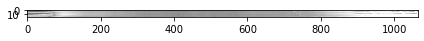

In [27]:
io.imshow(d)
io.show()

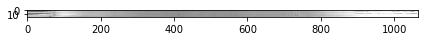

In [28]:
io.imshow(out)
io.show()

In [15]:
# Restore image

rows = 9129
cols = width
channels = 1

img_0 = np.fromfile('Test1_2_EPI_PAE5_0_r.raw', dtype='uint8')
#img_0 = img_0.reshape(rows, cols, channels)
img_0 = img_0.reshape(rows, cols)

img_1 = np.fromfile('Test1_2_EPI_PAE5_1_r.raw', dtype='uint8')
img_1 = img_1.reshape(rows, cols)

img_2 = np.fromfile('Test1_2_EPI_PAE5_2_r.raw', dtype='uint8')
img_2 = img_2.reshape(rows, cols)

d_r=np.zeros(shape=(9129,width,3))
d_r[:,:,0] = img_0
d_r[:,:,1] = img_1
d_r[:,:,2] = img_2

#cv2.imshow('Infared image',img)
# dtype transform
d_r=d_r.astype(np.uint8)
EPI_img_r = d_r

In [16]:
d_r = Image.fromarray(d_r,'RGB')
d_r.save('Test1_2_EPI_PAE5_r.png')

In [17]:
# EPI to PNG
img_array_r = np.empty((nums,height,width,3))
for rows in range(0,height):
    for s in range(0,17):
       img_array_r[s,rows,:,:] = EPI_img_r[rows*17+s,:,:]

i = 0
for filename in imagelist:
    #print(filename) #just for test
    #img is used to store the image data 
    img = img_array_r[i] 
    img=img.astype(np.uint8)
    img = Image.fromarray(img,'RGB')
    img.save('./Test1_2_PAE5_r/restore_' + filename)
    i = i + 1

In [22]:
EPI_cut = EPI_img_r[0:500,:,:]
EPI_cut=EPI_cut.astype(np.uint8)
EPI_cut = Image.fromarray(EPI_cut,'RGB')
EPI_cut.save('./EPI_cut.png')